### Thoughts from lit review
Paper 1 (Analyses of the data were conducted using grouping either by region or by population density):
- past studies show race and income / poverty are correlated - think about using therse as interaction terms?
- calculated mortality rates and use this as outcome (similar to paper) 
- possibly remove areas with low population density (as done in paper
- potentially do analysis on grouping by zipcode or population density (as done in paper)
- paper included monthly averages, where we use yearly based on zipcode - should we change this?
- paper used stepwise regression (refitting model, removing predictors at pvalue threshold of 0.03)
- do we have info on the availability of primary care within the zipcode level?

Paper 2: (57 factors)
- survival analysis: not really what I will do, but good to look at methods:
    - cox regression - risk of mortality
    - lasso regression with cross validation

Paper 3 (What weather variables are important in predicting heat-related mortality? A new application of statistical learning methods):
- Includes ICD9-codes (counts for specific diseases present that could affect mortality count)
    

### To do:
- simple logistic regression with single predictor (exposure)
- figuring out if need dummy variables for state code, other categorical variables
- bootstrapping
- cross validation
- calculate and plot confidence intervals
- calculate and plot residuals
- dimensionality reduction (pca?) potentially
- utilizing penalty terms (lasso and ridge)
- read literature to look at handled features in plotting
- read literature for other models used

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import PoissonRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
# map statecodes to integers
def map_statecode(df_sub):
    states = list(np.unique(df_sub.statecode, return_counts=True)[0])
    state_num = list(range(len(states)))
    state_dict = {}

    for i in range(len(states)):
        state_dict[states[i]] = state_num[i]

    def map_state_num(state):
        val = state_dict[state]
        return val

    df_sub['statecode'] = df_sub['statecode'].apply(map_state_num)
    return df_sub

def standardize(non_binary_predictors, X_train, X_test=None):
    
    scaler = StandardScaler().fit(X_train[non_binary_predictors])
    
    # if x_test is passed in, or just x_train 
    if X_test is not None:
        X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
        X_test[non_binary_predictors] = scaler.transform(X_test[non_binary_predictors])
        return X_train, X_test
    else:
        X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
        return X_train  


def split_and_standardize(df, x_cols, y_col, non_binary_preds, interact_cols=None,s=True):
        
    # split into train and test
    zips = np.unique(df.zip)
    zips_test = list(np.random.choice(zips, round(zips.shape[0]*.25)))
    zips_train  = [x for x in zips if x not in zips_test]

    df_train = df[df.zip.isin(zips_train)].sample(frac=1)
    df_test = df[df.zip.isin(zips_test)]
    
    # separate into X and y
    X_train, y_train = df_train[x_cols],df_train[y_col]
    X_test, y_test = df_test[x_cols],df_test[y_col]
    
    # standardize
    if s==True:
        X_train_standardized, X_test_standardized = standardize(non_binary_preds, X_train, X_test)
        print('after:',X_train_standardized.shape, y_train.shape)
        return X_train_standardized, y_train, X_test_standardized, y_test
    
    else:
        return X_train, y_train, X_test, y_test

**Simple Logistic Regression Model**

In [4]:
def simple_log_reg(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression().fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    train_pred = clf.predict_proba(X_train)
    test_pred = clf.predict_proba(X_test)
    
    return train_score,test_score,train_pred,test_pred

def plot_log_preds(df, X_train, X_test, train_preds, test_preds, x_col, y_col):
    plt.scatter(df[x_cols], df[y_col], label='True Vals')
    plt.scatter(X_train[x_cols], train_preds[:,1], label='Train Pred')
    plt.scatter(X_test[x_cols], test_preds[:,1], label='Test Pred')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title("Simple Logistic Regression Predictions")
    plt.legend()
    plt.show()

**Linear Regression**

In [5]:
def lin_reg(X_train, X_test, y_train, y_test):
        
    linreg_model = LinearRegression().fit(X_train, y_train)
    
    
    train_pred = linreg_model.predict(X_train)
    test_pred = linreg_model.predict(X_test)
    
    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    
    return train_pred, test_pred, r2_train, r2_test, linreg_model

def lasso_reg(X_train, X_test, y_train, y_test):
    
    lasso_reg = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
    non_important_coefs = X_train.columns[lasso_reg.coef_ == 0]
#     print("Lasso Coefficients = 0:", non_important_coefs)

    train_pred = lasso_reg.predict(X_train)
    test_pred = lasso_reg.predict(X_test)
    
    r2_train = lasso_reg.score(X_train, y_train)
    r2_test = lasso_reg.score(X_test, y_test)
    
    return train_pred, test_pred, r2_train, r2_test, non_important_coefs, lasso_reg

def plot_regression(X_train, y_train, X_test, y_test, train_preds, test_preds, x_lab, ylab, title):
    plt.scatter(X_train,y_train, label = 'train vals')
    plt.scatter(X_test,y_test, label = 'test vals')
    plt.scatter(X_train, train_preds, label='train preds')
    plt.scatter(X_test, test_preds, label='test preds')
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.title(title)
    plt.legend()
    plt.show()

In [38]:
def plot_residuals(X_test,y_test,test_pred):
    res = y_test - test_pred

    for c in X_test.columns:
        plt.scatter(X_test[c], res)
        plt.hlines(y=0,xmin=min(X_test[c]), 
                   xmax=max(X_test[c]),linestyles='dashed', label='y=0')
        plt.xlabel(c)
        plt.ylabel("test residuals")
        plt.legend()
        plt.show()

def check_linear_robustness(df_train, x_col, y_col):

    train_scores = []
    test_scores = []
    train_mse = []
    test_mse = [] 
    non_binary_preds = x_col
    train_preds = []
    test_preds = []
              
    for i in range(10):
        # resample and shuffle
        X_train_standardized, y_train, X_test_standardized, y_test = split_and_standardize(df_train, x_col, y_col, non_binary_preds)
        
        # build gbr
        train_pred, test_pred, r2_train, r2_test, linreg_model = lin_reg(X_train_standardized, X_test_standardized, y_train, y_test)
                
        train_scores.append(r2_train)
        test_scores.append(r2_test)
#         print(train_scores[-1],test_scores[-1])
        
        train_mse.append(mean_squared_error(y_train, train_pred))
        test_mse.append(mean_squared_error(y_test, test_pred))
        train_preds.append(train_pred)
        test_preds.append(test_pred)
#         print('completed round')
                    
    return train_scores, test_scores, train_mse, test_mse, train_preds, test_preds

def plot_pred(X_train_standardized_2011, y_train_2011, X_test_standardized_2011, y_test_2011, train_pred,test_pred):
    plt.scatter(X_train_standardized_2011, y_train_2011, label='train vals')
    plt.scatter(X_train_standardized_2011, train_pred, label='train pred', color='orange')
    plt.scatter(X_test_standardized_2011, y_test_2011, label='test vals')
    plt.scatter(X_test_standardized_2011, test_pred, label='test pred', color='red')
    plt.title('Death Count Predictions for 2012')
    plt.xlabel('CVD Count')
    plt.ylabel('Death Count')
    plt.legend()
    plt.show()

### Modeling on Data set aggregated by  zip, and year

In [10]:
df_train = pd.read_csv('zip_train_yearly.csv')
df_test= pd.read_csv('zip_test_yearly.csv')

**Simple linear regression**

In [11]:
x_col1 = ['pm25_summer_4y_avg', 'pm25_winter_4y_avg',
'pm25_fall_4y_avg', 'pm25_spring_4y_avg', 'ozone_summer_4y_avg',
'ozone_winter_4y_avg', 'ozone_fall_4y_avg', 'ozone_spring_4y_avg',
'no2_summer_4y_avg', 'no2_winter_4y_avg', 'no2_fall_4y_avg',
'no2_spring_4y_avg', 'summer_tmmx_4y_avg', 'summer_rmax_4y_avg',
'winter_tmmx_4y_avg', 'winter_rmax_4y_avg']

# x_col1 = ['pm25_summer_4y_avg','summer_tmmx_4y_avg']

y_col1 = 'deaths_next_year'
non_binary_preds = x_col1

# split into train and test and standardize
X_train_standardized1, y_train1, X_test_standardized1, y_test1 = split_and_standardize(df_train, x_col1, y_col1, non_binary_preds)

# model
train_pred1, test_pred1, r2_train1, r2_test1, linreg_model1 = lin_reg(X_train_standardized1, X_test_standardized1, y_train1, y_test1)
print(r2_train1, r2_test1)

after: (61600, 16) (61600,)
0.12628620491554332 0.13230264205265585


Environmental predictors alone are not great at predicting mortality count

In [12]:
df_train_2011 = df_train[df_train['AYEAR'] == 2011]

x_col = ['CVD_pdx2dx_25']
y_col = 'deaths_next_year'
non_binary_preds = x_col

# split into train and test and standardize
X_train_standardized_2011, y_train_2011, X_test_standardized_2011, y_test_2011 = split_and_standardize(df_train_2011, x_col, y_col, non_binary_preds)

# model
train_pred, test_pred, r2_train, r2_test,linreg_model2 = lin_reg(X_train_standardized_2011, X_test_standardized_2011, y_train_2011, y_test_2011)
print(r2_train, r2_test)

after: (12294, 1) (12294,)
0.8208890941476993 0.8106677119974987


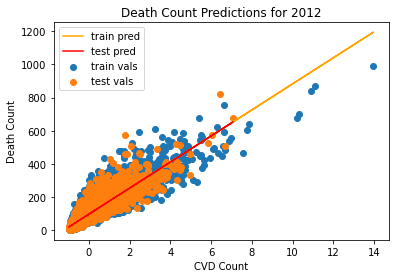

In [13]:
plt.scatter(X_train_standardized_2011, y_train_2011, label='train vals')
plt.plot(X_train_standardized_2011, train_pred, label='train pred', color='orange')
plt.scatter(X_test_standardized_2011, y_test_2011, label='test vals')
plt.plot(X_test_standardized_2011, test_pred, label='test pred', color='red')
plt.title('Death Count Predictions for 2012')
plt.xlabel('CVD Count')
plt.ylabel('Death Count')
plt.legend()
plt.show()

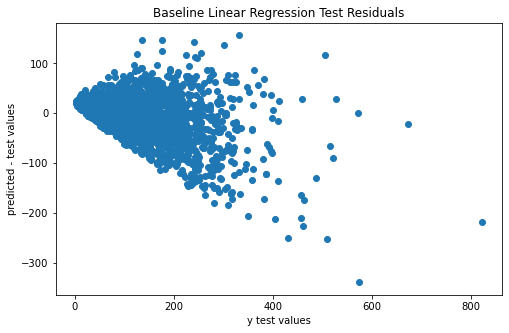

In [14]:
f,ax = plt.subplots(1, figsize=(8,5))
ax.scatter(y_test_2011, test_pred - y_test_2011)
ax.set_title('Baseline Linear Regression Test Residuals')
ax.set_xlabel('y test values')
ax.set_ylabel('predicted - test values')
# f.savefig('model1_residuals.png')
plt.show()

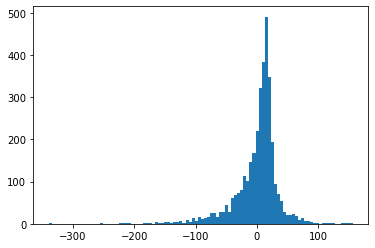

In [15]:
plt.hist(test_pred - y_test_2011, bins=100)
plt.show()
# residuals do not follow normality assummption, which means we cannot draw valid conclusion
## based on statistical inference

Poisson Regression

In [15]:
pr_model = PoissonRegressor().fit(X_train_standardized_full, y_train_full)
pr_train_pred, pr_test_pred = pr_model.predict(X_train_standardized_full), pr_model.predict(X_test_standardized_full)
pr_test_pred = pr_model.predict(X_test_standardized_full)

print(pr_model.score(X_test_standardized_full, y_test_full))
print(mean_squared_error(pr_test_pred,y_test_full))
print(mean_squared_error(pr_test_pred,y_test_full,squared=False))

0.6730975156244647
15298.265514494586
123.6861573277082


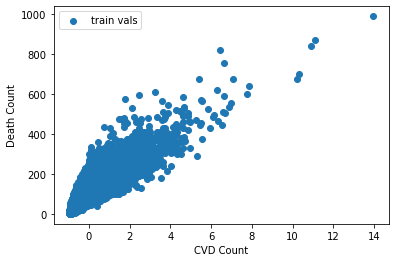

In [22]:
plt.scatter(X_train_standardized_2011, y_train_2011, label='train vals')
plt.xlabel('CVD Count')
plt.ylabel('Death Count')
plt.legend()
plt.show()

Polynomial Regression

Degree: 1


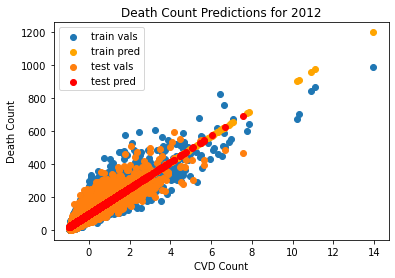

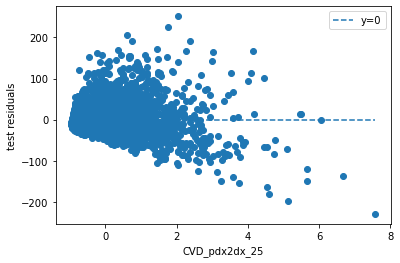

Degree: 2


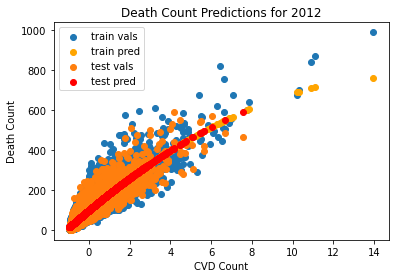

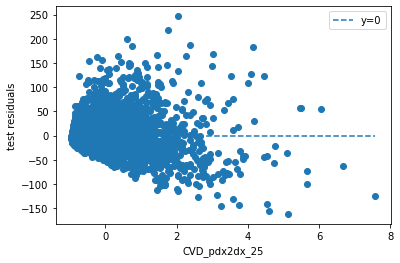

Degree: 3


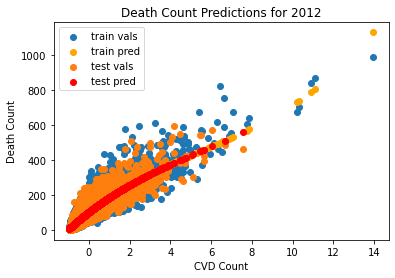

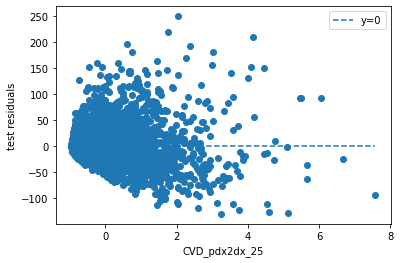

Degree: 4


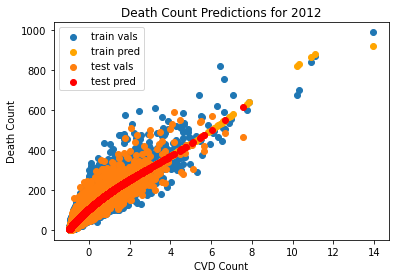

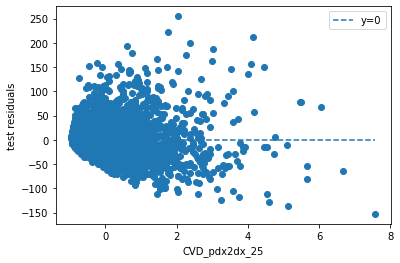

Degree: 5


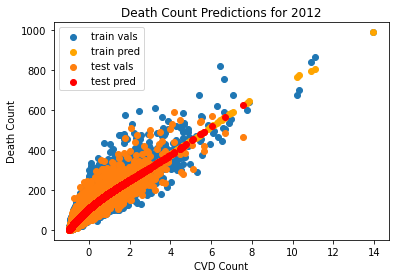

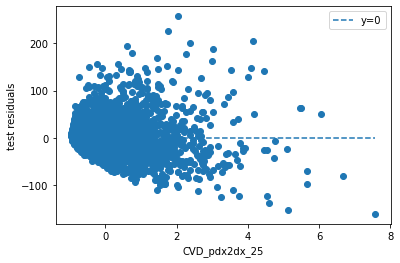

Degree: 6


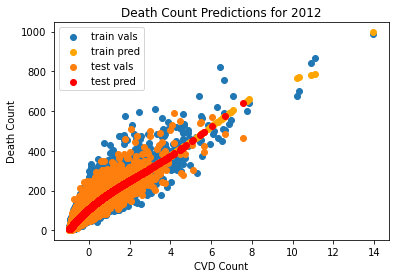

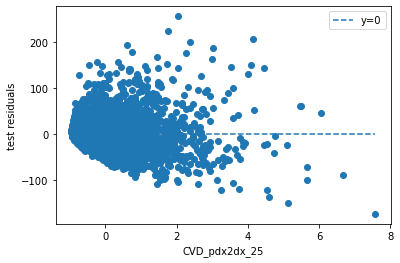

Degree: 10


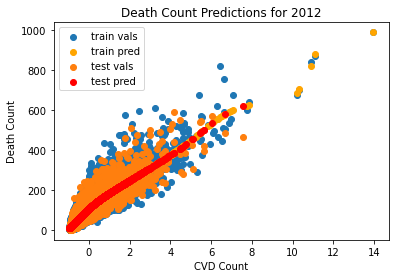

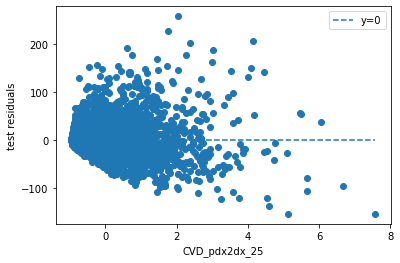

Degree: 15


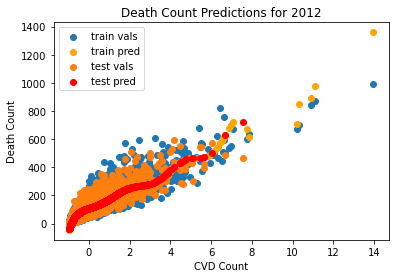

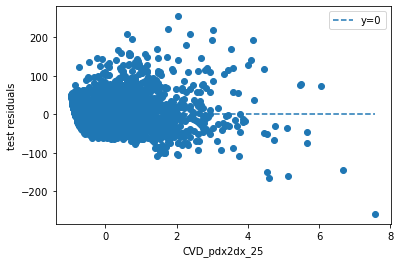

In [25]:
degrees = [1,2,3,4,5,6,10,15]
for d in degrees:
    
    model = make_pipeline(PolynomialFeatures(d), LinearRegression())
    model.fit(X_train_standardized_2011, y_train_2011)
    
    train_pred, test_pred = model.predict(X_train_standardized_2011), model.predict(X_test_standardized_2011)
    
    print('Degree:', d)
    plot_pred(X_train_standardized_2011, y_train_2011, X_test_standardized_2011, y_test_2011, train_pred,test_pred)
    plot_residuals(X_test_standardized_2011,y_test_2011,test_pred)

In [26]:
num_b = 50
bootstrapped_test_pred = np.zeros((X_test_standardized_2011.shape[0],num_b))

for i in range(num_b):
    X_train_sub = X_train_standardized_2011.sample(frac=1)
              
    model = make_pipeline(PolynomialFeatures(10), LinearRegression())
    model.fit(X_train_standardized_2011, y_train_2011)
    
    test_pred = model.predict(X_test_standardized_2011)

    bootstrapped_test_pred[:,i] = test_pred

#     plot_pred(X_train_standardized_2011, y_train_2011, X_test_standardized_2011, y_test_2011, train_pred,test_pred)
#     plot_residuals(X_test_standardized_2011,y_test_2011,test_pred)    
    

In [27]:
agg_test_pred = bootstrapped_test_pred.mean(axis=1)

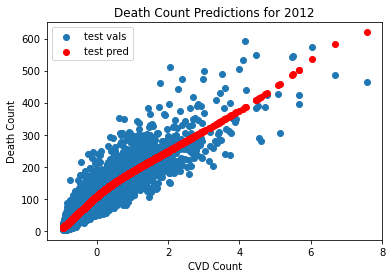

In [28]:
plt.scatter(X_test_standardized_2011, y_test_2011, label='test vals')
plt.scatter(X_test_standardized_2011, agg_test_pred, label='test pred', color='red')
plt.title('Death Count Predictions for 2012')
plt.xlabel('CVD Count')
plt.ylabel('Death Count')
plt.legend()
plt.show()

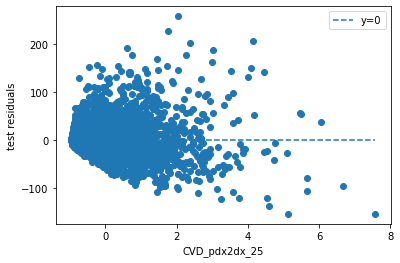

In [29]:
plot_residuals(X_test_standardized_2011,y_test_2011,agg_test_pred)

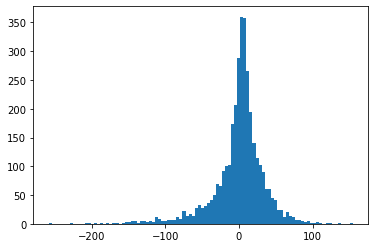

In [30]:
plt.hist(agg_test_pred - y_test_2011, bins=100)
plt.show()

Baseline model with all years

In [31]:
x_col = ['CVD_pdx2dx_25','COPD_pdx2dx_25','neo_150_159','ICU_DAY']
y_col = 'deaths_next_year'
non_binary_preds = ['CVD_pdx2dx_25','COPD_pdx2dx_25','neo_150_159','ICU_DAY']

# split into train and test and standardize
X_train_standardized, y_train, X_test_standardized, y_test = split_and_standardize(df_train, x_col, y_col, non_binary_preds)

# model
train_pred, test_pred, r2_train, r2_test, linreg_model3 = lin_reg(X_train_standardized, X_test_standardized, y_train, y_test)
print(r2_train, r2_test)

before: (61360, 4) (61360,)
after: (61360, 4) (61360,)
0.8205216450326575 0.8081873846518874


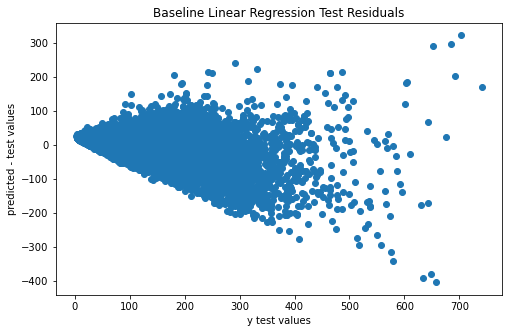

In [32]:
f,ax = plt.subplots(1, figsize=(8,5))
ax.scatter(y_test, test_pred - y_test)
ax.set_title('Baseline Linear Regression Test Residuals')
ax.set_xlabel('y test values')
ax.set_ylabel('predicted - test values')
f.savefig('model1_residuals.png')
plt.show()

In [33]:
#Compute the MSE of the model
print("MSE of train data",mean_squared_error(y_train, train_pred))
print("MSE of test data",mean_squared_error(y_test, test_pred))

MSE of train data 1409.3278561899028
MSE of test data 1556.8476059460738


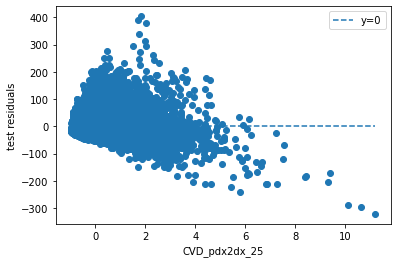

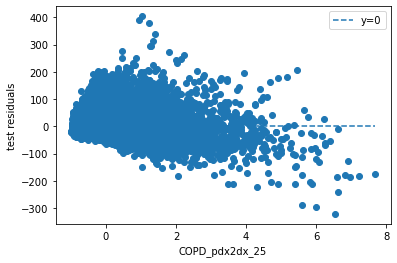

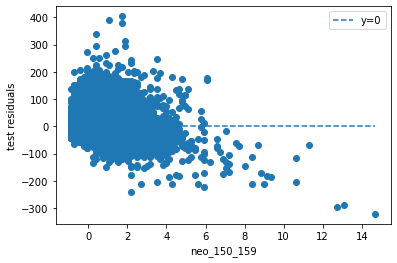

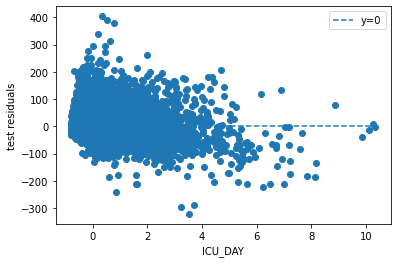

In [34]:
plot_residuals(X_test_standardized, y_test, test_pred)

Model Interaction terms

In [36]:
linreg_model_interact = LinearRegression().fit(X_train_standardized['ICU_DAY'].values.reshape(-1,1),X_train_standardized['CVD_pdx2dx_25'].values.reshape(-1,1))

interact_train_pred = linreg_model_interact.predict(X_train_standardized['ICU_DAY'].values.reshape(-1,1))
interact_test_pred = linreg_model_interact.predict(X_test_standardized['ICU_DAY'].values.reshape(-1,1))

r2_interact_train = r2_score(X_train_standardized['CVD_pdx2dx_25'], interact_train_pred)
r2_interact_test = r2_score(X_test_standardized['CVD_pdx2dx_25'], interact_test_pred)
print(r2_interact_train, r2_interact_test)

0.6564476364824513 0.6333308861378771


In [37]:
# add interaction term
interact_cols={'ICU_DAY*CVD_pdx2dx_25':['ICU_DAY', 'CVD_pdx2dx_25']}

# zip_df_2011 = zip_df[zip_df.AYEAR == 2011]

x_col = ['CVD_pdx2dx_25','COPD_pdx2dx_25','neo_150_159','ICU_DAY']
y_col = 'deaths_next_year'
non_binary_preds = ['CVD_pdx2dx_25','COPD_pdx2dx_25','neo_150_159','ICU_DAY']

# split into train and test and standardize
X_train_standardized_interact, y_train_interact, X_test_standardized_interact, y_test_interact = split_and_standardize(df_train, x_col, y_col, non_binary_preds, interact_cols)

# model
train_pred2, test_pred2, r2_train2, r2_test2, linreg_model4 = lin_reg(X_train_standardized_interact, X_test_standardized_interact, y_train_interact, y_test_interact)
print(r2_train2, r2_test2)

before: (61625, 4) (61625,)
after: (61625, 4) (61625,)
0.8142757526702151 0.8293463161470862


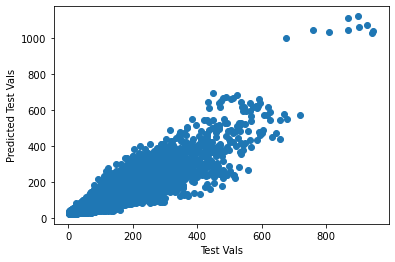

In [38]:
plt.show()
plt.scatter(y_test_interact, test_pred2)
plt.xlabel("Test Vals")
plt.ylabel("Predicted Test Vals")
plt.show()

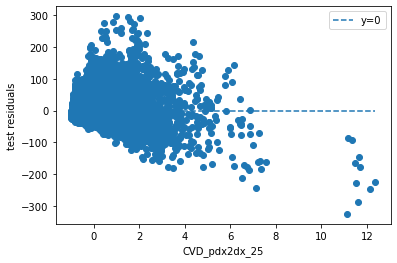

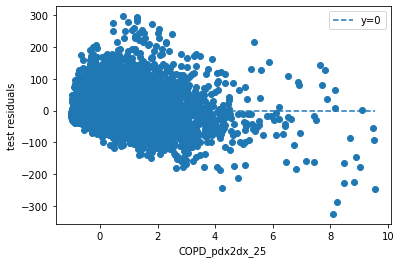

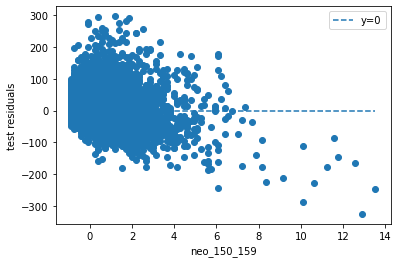

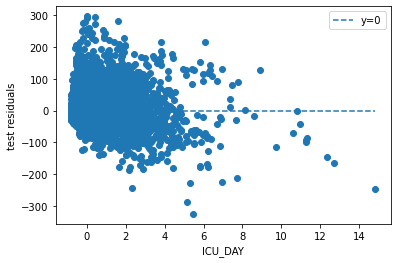

In [39]:
plot_residuals(X_test_standardized_interact, y_test_interact, test_pred2)

**Multiple Linear Regression**

In [16]:
x_col = ['age','poverty', 'popdensity', 'medianhousevalue', 
        'medhouseholdincome', 'pct_owner_occ','education',
        'smoke_rate', 'mean_bmi', 'rmax', 'pr', 'race_0', 'race_1', 'race_2',
        'race_3', 'race_4', 'race_5', 'race_6',
         'ICU_DAY', 'CCI_DAY', 'LOS', 
        'Parkinson_pdx2dx_25','Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25', 'CHF_pdx2dx_25',
       'AMI_pdx2dx_25', 'COPD_pdx2dx_25', 'DM_pdx2dx_25', 'Stroke_pdx2dx_25',
       'CVD_pdx2dx_25', 'Ischemic_stroke_pdx2dx_25','Hemo_Stroke_pdx2dx_25',
        'neo_140_149', 'neo_150_159', 'neo_160_165',
       'neo_170_176', 'neo_179_189', 'neo_190_199', 'neo_200_209',
       'neo_210_229', 'neo_230_234', 'neo_235_238', 'neo_239'] + x_col1

y_col = 'deaths_next_year'
non_binary_preds = x_col

# split into train and test and standardize
X_train_standardized_full, y_train_full, X_test_standardized_full, y_test_full = split_and_standardize(df_train, x_col, y_col, non_binary_preds)

# model
lin_train_pred, lin_test_pred, lin_r2_train, lin_r2_test, linreg_model = lin_reg(X_train_standardized_full, X_test_standardized_full, y_train_full, y_test_full)
lasso_train_pred, lasso_test_pred, lasso_r2_train, lasso_r2_test, lasso_coef, lasso_model = lasso_reg(X_train_standardized_full, X_test_standardized_full, y_train_full, y_test_full)

print("Linear Regression train pred:", lin_r2_train, ", test pred:", lin_r2_test)
print("Lasso Regression train pred:",lasso_r2_train, ", test pred:",lasso_r2_test)

after: (61490, 59) (61490,)
Linear Regression train pred: 0.8622955288652461 , test pred: 0.8704208062751628
Lasso Regression train pred: 0.8612608196229357 , test pred: 0.8689948219278535


In [18]:
#Compute the MSE of the model
print("MSE of train data:",mean_squared_error(y_train_full,lin_train_pred))
print("MSE of test data:",mean_squared_error(y_test_full, lin_test_pred))

MSE of train data: 1085.0859717032793
MSE of test data: 1039.831248320729


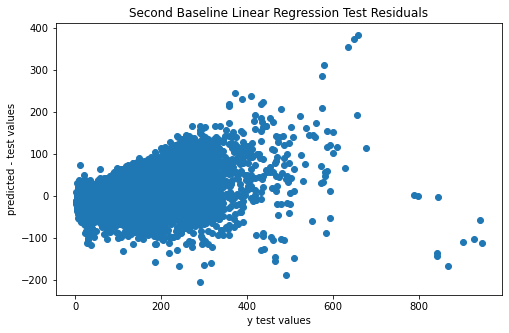

In [19]:
f,ax = plt.subplots(1, figsize=(8,5))
ax.scatter(y_test_full, (y_test_full - lin_test_pred).values)
ax.set_title('Second Baseline Linear Regression Test Residuals')
ax.set_xlabel('y test values')
ax.set_ylabel('predicted - test values')
f.savefig('model2_residuals.png')


In [39]:
# linear regression robustness
mlr_train_scores, mlr_test_scores, mlr_train_mse, mlr_test_mse, mlr_train_preds, mlr_test_preds = check_linear_robustness(df_train, x_col, y_col)

after: (61465, 59) (61465,)
after: (61270, 59) (61270,)
after: (61325, 59) (61325,)
after: (61545, 59) (61545,)
after: (61515, 59) (61515,)
after: (61470, 59) (61470,)
after: (61530, 59) (61530,)
after: (61495, 59) (61495,)
after: (61550, 59) (61550,)
after: (61505, 59) (61505,)


In [40]:
labs = ['mlr train r2','mlr test r2','mlr train mse','mlr test mse']
for i,s in enumerate([mlr_train_scores, mlr_test_scores, mlr_train_mse, mlr_test_mse]):
    print(labs[i],' : ',np.mean(s))

mlr train r2  :  0.8592849829057656
mlr test r2  :  0.8577717133376535
mlr train mse  :  1119.0344318864759
mlr test mse  :  1102.3174401250074


In [43]:
np.mean([np.sqrt(i) for i in mlr_test_mse])

33.18679415426948

In [1]:
# pd.DataFrame([np.sqrt(i) for i in mlr_test_mse]).describe()

In [2]:

# pd.DataFrame(mlr_test_mse).describe()

In [3]:

# pd.DataFrame(mlr_test_scores).describe()

Poisson on whole data set

In [42]:
pr_model_full = PoissonRegressor().fit(X_train_standardized_full, y_train_full)

pr_train_pred_full, pr_test_pred_full = pr_model_full.predict(X_train_standardized_full),pr_model_full.predict(X_test_standardized_full)
print(pr_model_full.score(X_test_standardized_full, y_test_full))


0.6702859126108628


**Look closer at Interaction terms for collinearity**

In [45]:
# find relationship between ICU_DAY and CVD_pdx2dx_25
def simple_log_reg(X_train_standardized, X_test_standardized, y_train, y_test):
    linreg_model_interact = LinearRegression().fit(X_train_standardized.values.reshape(-1,1),y_train.values.reshape(-1,1))

    interact_train_pred = linreg_model_interact.predict(X_train_standardized.values.reshape(-1,1))
    interact_test_pred = linreg_model_interact.predict(X_test_standardized.values.reshape(-1,1))

    r2_interact_train = r2_score(X_train_standardized, interact_train_pred)
    r2_interact_test = r2_score(X_test_standardized, interact_test_pred)
    print(r2_interact_train, r2_interact_test)

# run code
x_cols = ['poverty', 'poverty','medianhousevalue', 'poverty', 'poverty', 'education', 'education',
         'CVD_pdx2dx_25', "ICU_DAY", "Alzheimer_pdx2dx_25", 'CVD_pdx2dx_25', 'Stroke_pdx2dx_25',
         'Stroke_pdx2dx_25', 'Ischemic_stroke_pdx2dx_25', 'Alzheimer_pdx2dx_25', 'summer_tmmx_4y_avg',
         'summer_rmax_4y_avg', 'pm25_winter_4y_avg']
y_cols = ['popdensity', 'medianhousevalue', 'medhouseholdincome', 'medhouseholdincome', 'education', 
         'CHF_pdx2dx_25', 'CCI_DAY', "Dementia_pdx2dx_25", 'COPD_pdx2dx_25',
         'Ischemic_stroke_pdx2dx_25', 'Hemo_Stroke_pdx2dx_25', 'Hemo_Stroke_pdx2dx_25', 'Dementia_pdx2dx_25',
         'winter_tmmx_4y_avg', 'winter_tmmx_4y_avg', 'pm25_summer_4y_avg','summer_tmmx_4y_avg', 'pm25_summer_4y_avg']

for i in range(len(x_cols)):
    x = x_cols[i]
    y = y_cols[i]
    print(x,"and",y,":")
    simple_log_reg(X_train_standardized_full[x], X_test_standardized_full[x], X_train_standardized_full[y], X_test_standardized_full[y])
    print('\n')

poverty and popdensity :
0.393540943063164 0.39353075075744404


poverty and medianhousevalue :
-0.5373518248865077 -0.5373776620137123


medianhousevalue and medhouseholdincome :
0.9251253327840033 0.925124666259035


poverty and medhouseholdincome :
-1.2547243590109374 -1.2547622524840722


poverty and education :
0.8525173387759744 0.8525148601447223


education and CHF_pdx2dx_25 :
-0.024480642194793623 -0.02483037722230308


education and CCI_DAY :
0.014385305422755068 0.014048838369962624


CVD_pdx2dx_25 and Dementia_pdx2dx_25 :
0.9338542968602219 0.9338514571044904


ICU_DAY and COPD_pdx2dx_25 :
0.9452539855386121 0.9452519394766968


Alzheimer_pdx2dx_25 and Ischemic_stroke_pdx2dx_25 :
0.9500762969823799 0.9500627303956254


CVD_pdx2dx_25 and Hemo_Stroke_pdx2dx_25 :
0.9364702741667109 0.9364675467196584


Stroke_pdx2dx_25 and Hemo_Stroke_pdx2dx_25 :
0.9506647139230887 0.9506628902835769


Stroke_pdx2dx_25 and Dementia_pdx2dx_25 :
0.9042766698347098 0.9042731314981364


Ischemic_s

**Incorporate Some Interaction Terms**

In [9]:
interact_cols={'ICU_DAY*CVD_pdx2dx_25':['ICU_DAY', 'CVD_pdx2dx_25'],
              'medianhousevalue*medhouseholdincome':['medianhousevalue', 'medhouseholdincome'],
              'poverty*medhouseholdincome':['poverty', 'medhouseholdincome'],
              'CVD_pdx2dx_25*CHF_pdx2dx_25':['ICU_DAY', 'CVD_pdx2dx_25'],
              'Alzheimer_pdx2dx_25*Dementia_pdx2dx_25':['Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25'],
              'summer_tmmx_4y_avg*winter_tmmx_4y_avg':['summer_tmmx_4y_avg', 'winter_tmmx_4y_avg'],
              'summer_rmax_4y_avg*winter_rmax_4y_avg':['summer_rmax_4y_avg', 'winter_rmax_4y_avg'],
              'pm25_winter_4y_avg*pm25_summer_4y_avg':['pm25_winter_4y_avg', 'pm25_summer_4y_avg']}

y_col = 'deaths_next_year'
non_binary_preds = x_col + list(interact_cols.keys())

# split into train and test and standardize
X_train_standardized_full2, y_train_full2, X_test_standardized_full2, y_test_full2 = split_and_standardize(df_train, x_col, y_col, non_binary_preds, interact_cols)

# model
lin_train_pred2, lin_test_pred2, lin_r2_train2, lin_r2_test2, linreg_model5 = lin_reg(X_train_standardized_full2, X_test_standardized_full2, y_train_full2, y_test_full2)
lasso_train_pred2, lasso_test_pred2, lasso_r2_train2, lasso_r2_test2, lasso_coef2,lasso_m1 = lasso_reg(X_train_standardized_full2, X_test_standardized_full2, y_train_full2, y_test_full2)

print("Linear Regression train pred:",lin_r2_train2,", test pred:", lin_r2_test2)
print("Lasso Regression train pred:",lasso_r2_train2,", test pred:", lasso_r2_test2)

In [10]:
# for i in range(lasso_m1.coef_.shape[0]):
#     print(non_binary_preds[i], lasso_m1.coef_[i])

**Lasso Regression with all interaction terms**


In [20]:
poly = PolynomialFeatures(interaction_only=True)
X_poly = poly.fit_transform(df_train[x_col+['zip']])

poly_names = poly.get_feature_names(df_train[x_col+['zip']].columns) 
X_poly_df = pd.DataFrame(X_poly, columns = poly_names)
X_poly_df['deaths_next_year'] = df_train['deaths_next_year']

y_col = 'deaths_next_year'
non_binary_preds = poly_names[1:] 

# split into train and test and standardize
X_train_standardized_full3, y_train_full3, X_test_standardized_full3, y_test_full3 = split_and_standardize(X_poly_df.iloc[:,1:], poly_names[1:], y_col, non_binary_preds)

# model
lasso_train_pred3, lasso_test_pred3, lasso_r2_train3, lasso_r2_test3, non_important_coefs,lasso_m2 = lasso_reg(X_train_standardized_full3, X_test_standardized_full3, y_train_full3, y_test_full3)

print("Lasso Regression train pred:",lasso_r2_train3,", test pred:", lasso_r2_test3)

after: (61550, 1830) (61550,)
Lasso Regression train pred: 0.8716172257778055 , test pred: 0.8723408126237355


In [22]:
#Compute the MSE of the model
print("MSE of train data:",mean_squared_error(y_train_full3,lasso_train_pred3))
print("MSE of test data:",mean_squared_error(y_test_full3, lasso_test_pred3))

print(len(non_binary_preds) - len(non_important_coefs))
important_pred = list(set(non_binary_preds) - set(non_important_coefs))

MSE of train data: 1028.9246315087619
MSE of test data: 962.853400639485
72


In [23]:
print(mean_squared_error(lasso_test_pred3,y_test_full3))
print(mean_squared_error(lasso_test_pred3,y_test_full3, squared=False))

962.853400639485
31.02987915927945


In [112]:
list(lasso_m2.coef_[lasso_m2.coef_!=0]).shape

(147,)

In [4]:
# {i:j for i,j i n zip(important_pred,list(lasso_m2.coef_[lasso_m2.coef_!=0]))}

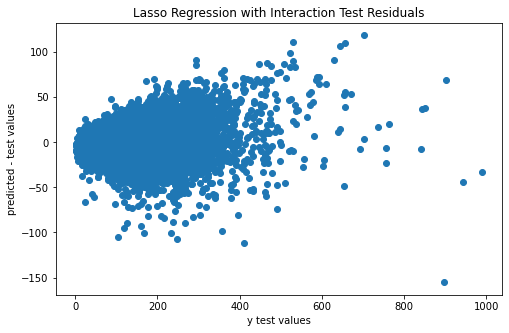

In [114]:
f,ax = plt.subplots(1, figsize=(8,5))
ax.scatter(y_test_full3, y_test_full3 - lasso_test_pred3)
ax.set_title('Lasso Regression with Interaction Test Residuals')
ax.set_xlabel('y test values')
ax.set_ylabel('predicted - test values')
f.savefig('model3_residuals.png')


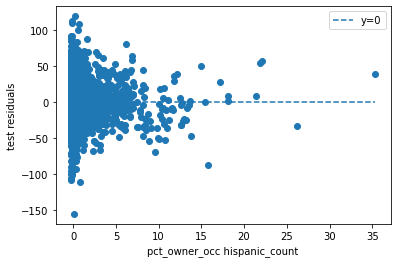

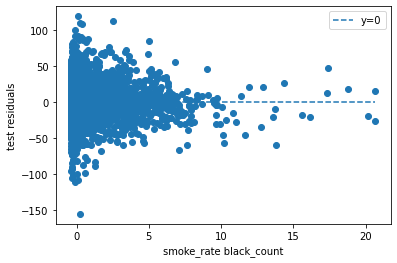

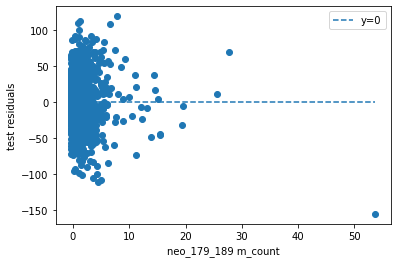

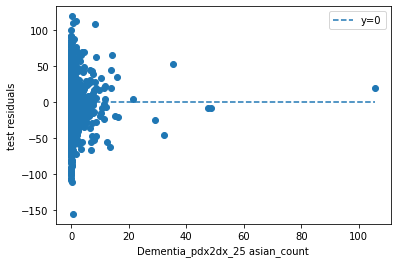

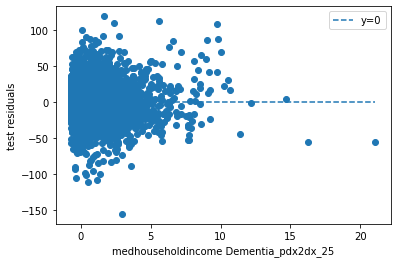

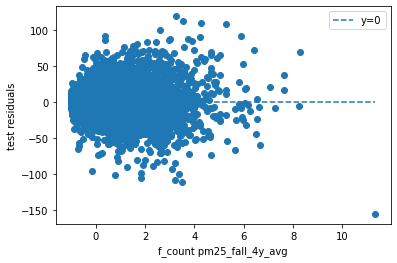

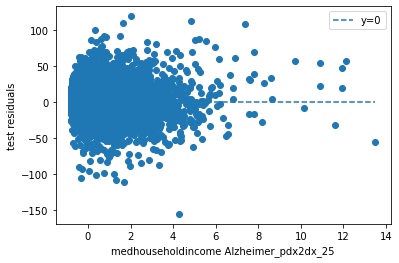

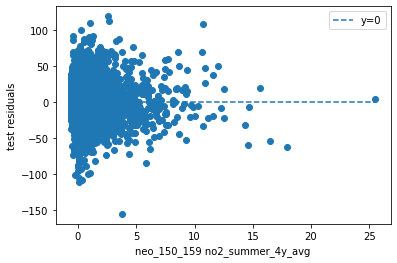

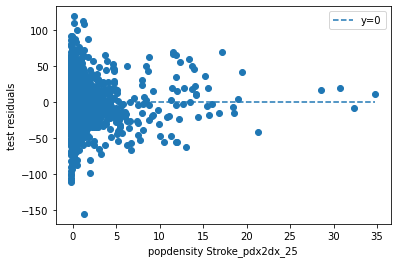

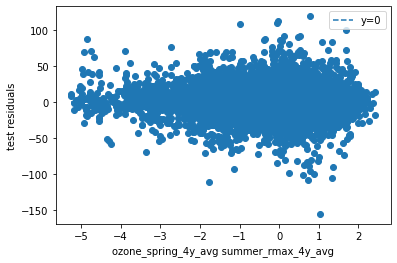

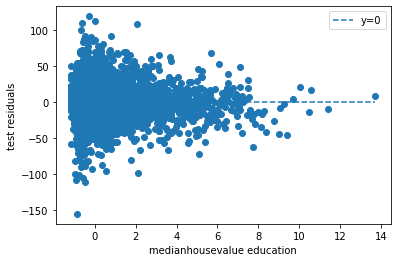

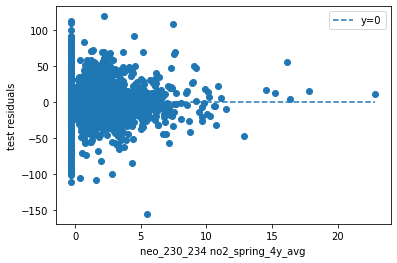

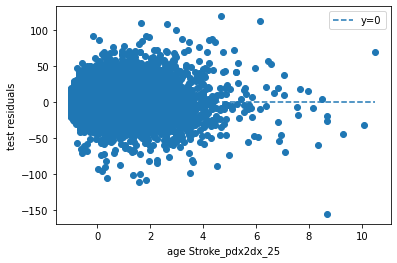

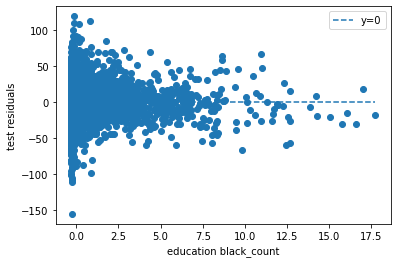

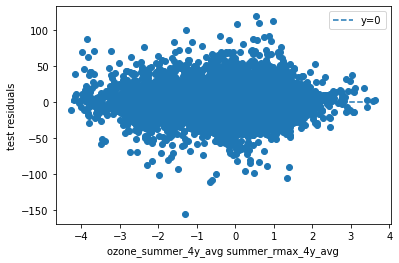

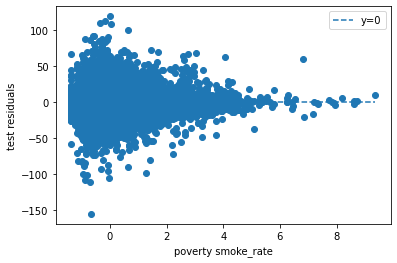

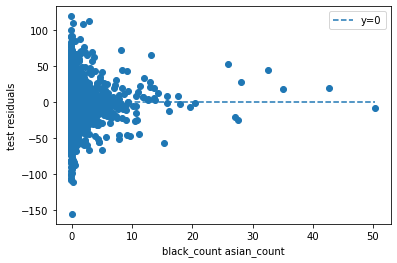

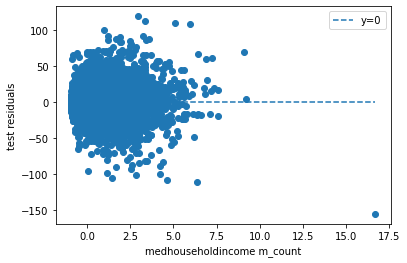

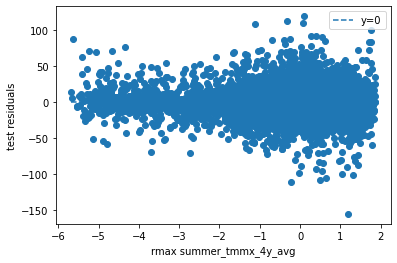

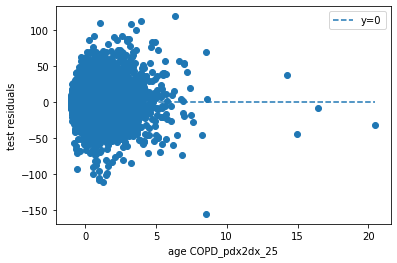

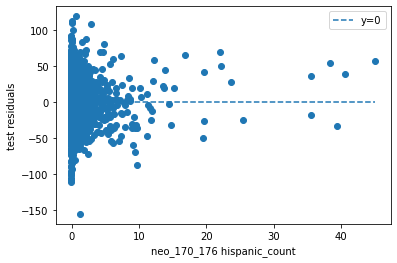

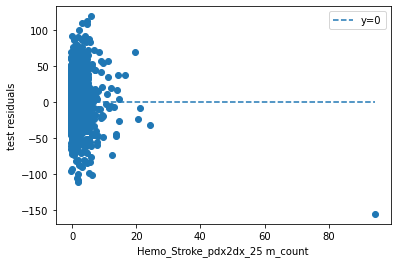

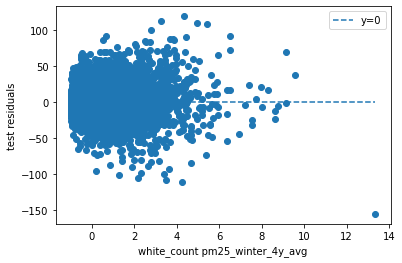

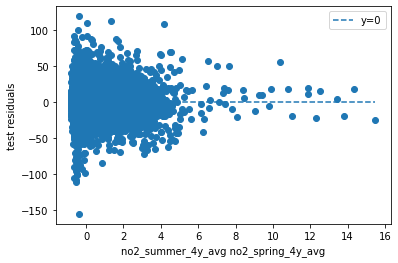

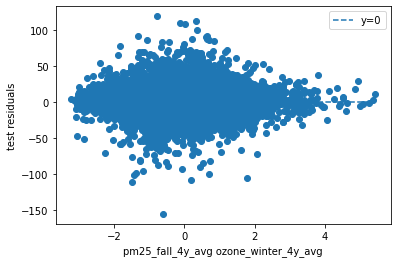

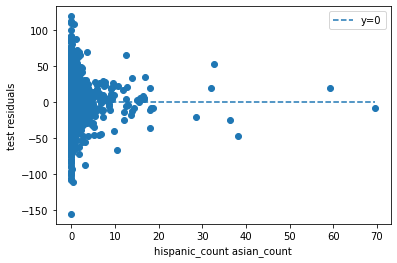

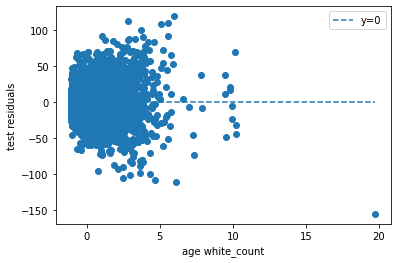

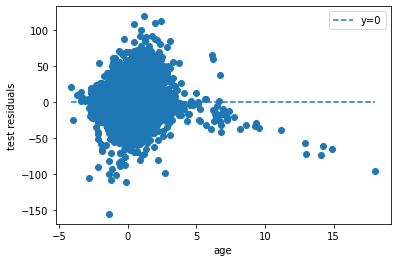

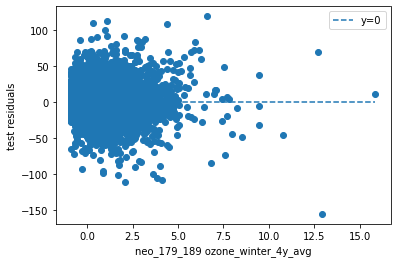

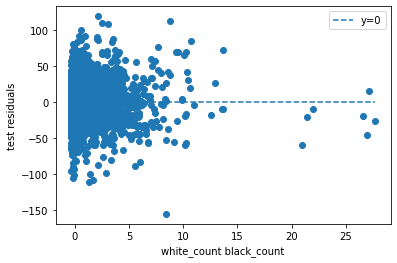

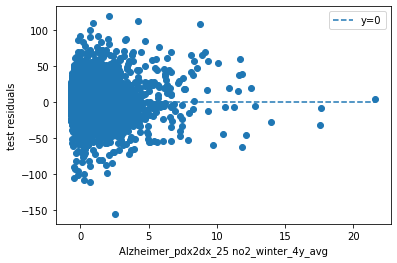

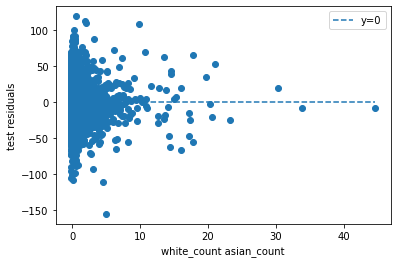

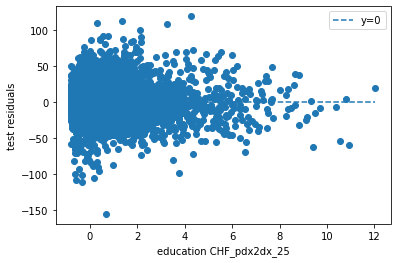

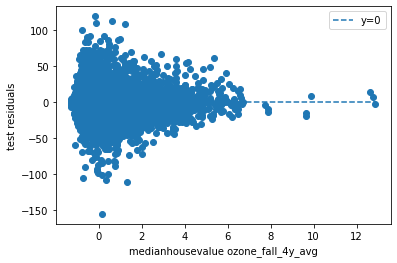

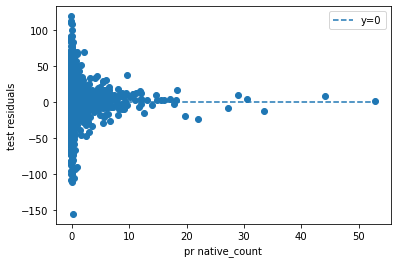

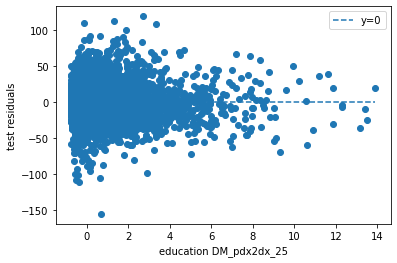

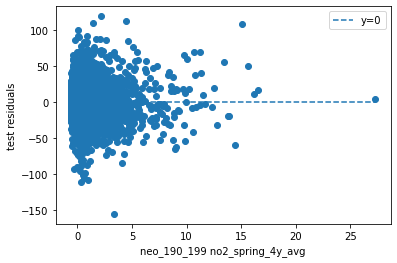

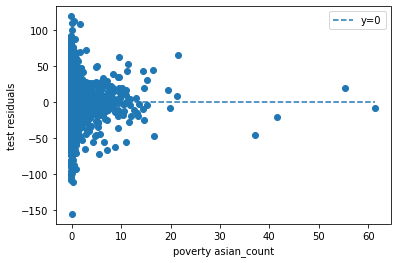

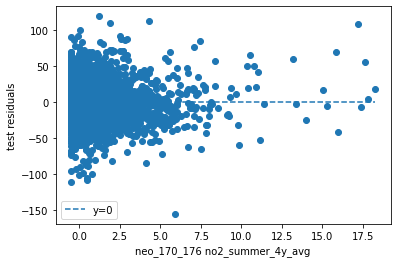

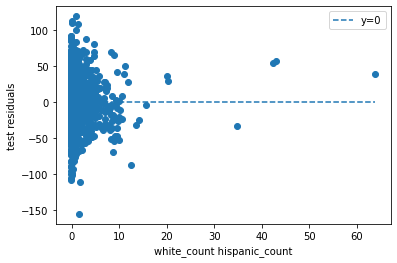

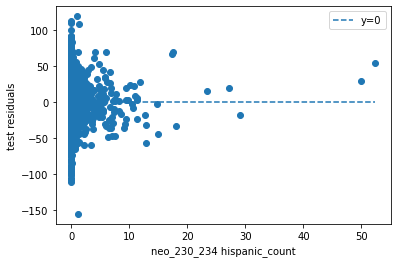

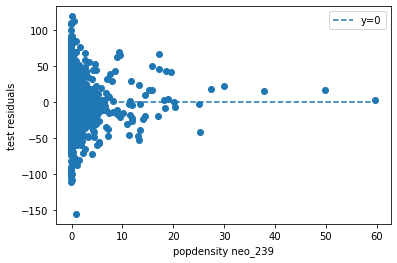

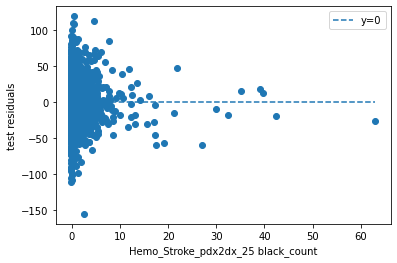

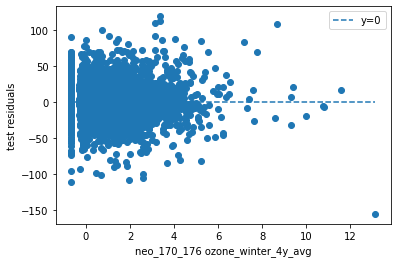

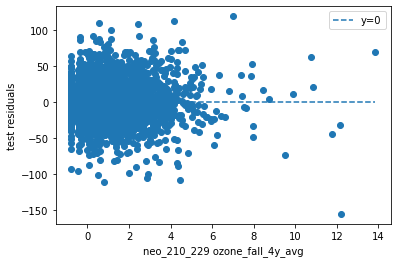

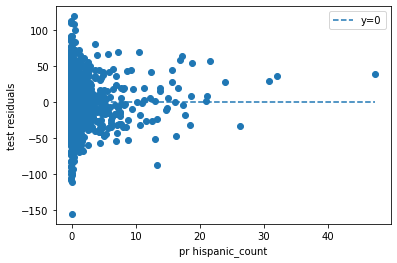

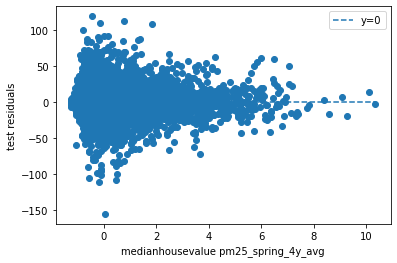

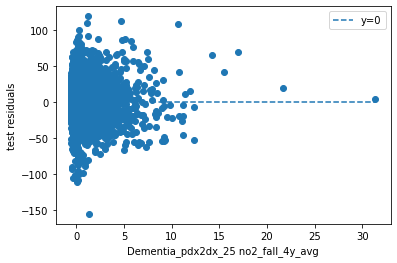

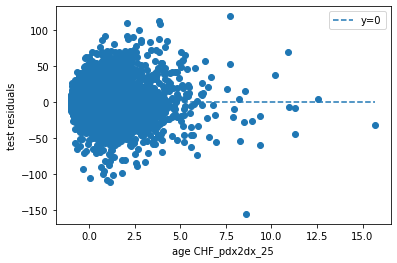

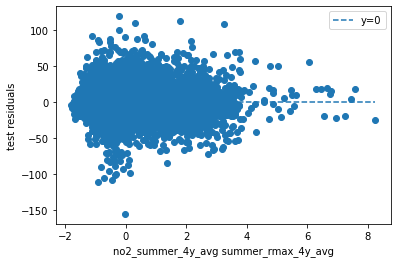

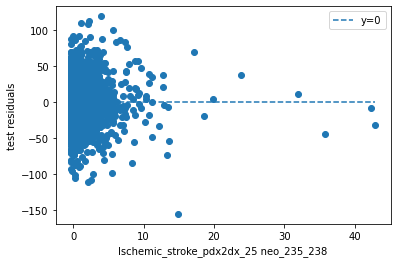

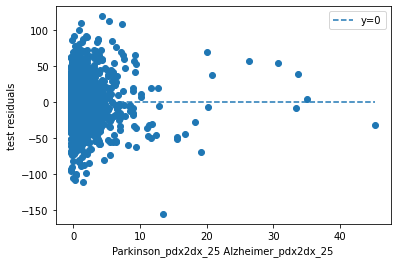

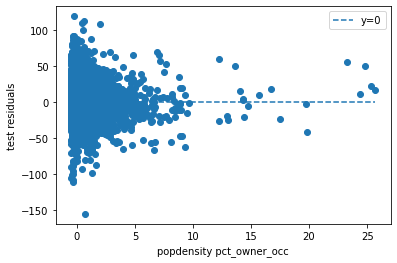

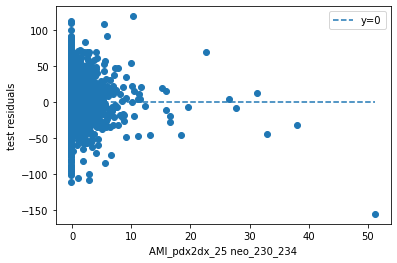

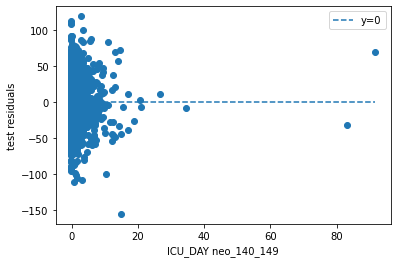

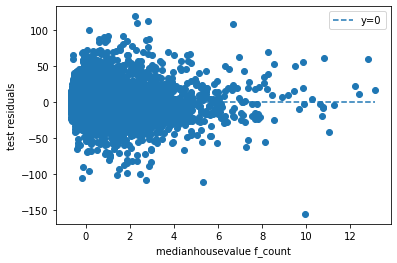

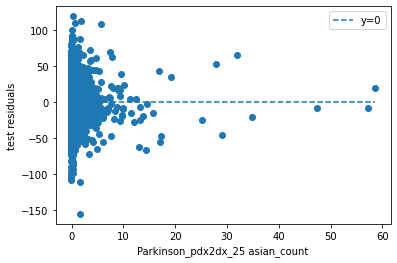

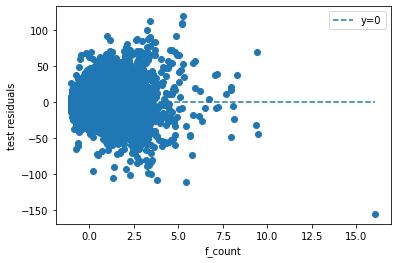

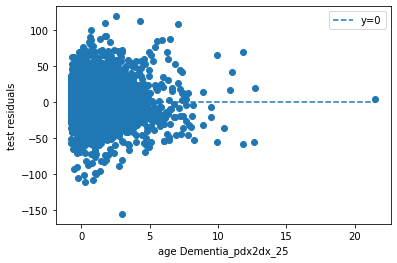

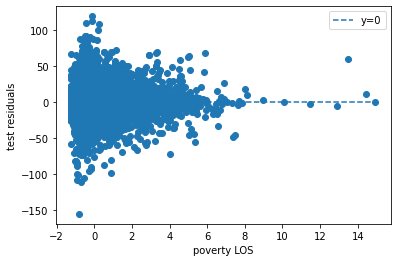

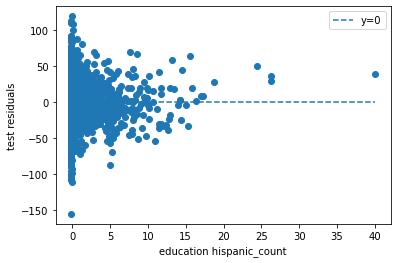

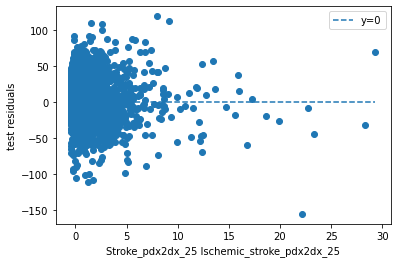

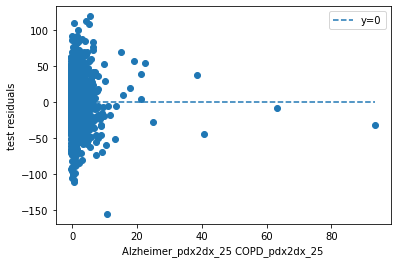

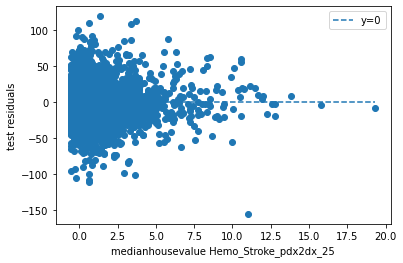

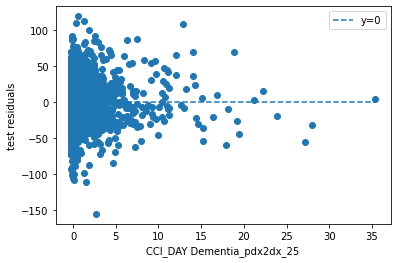

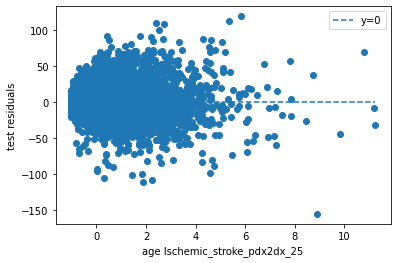

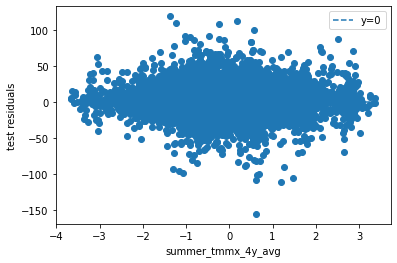

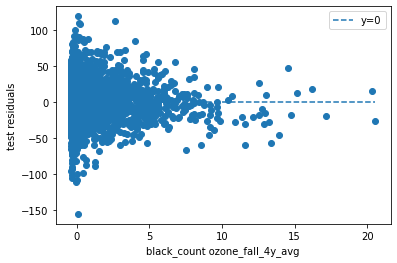

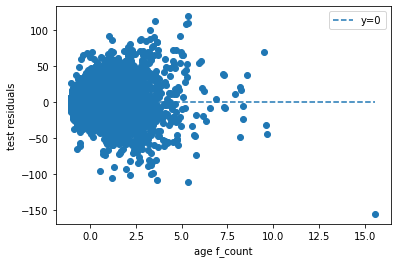

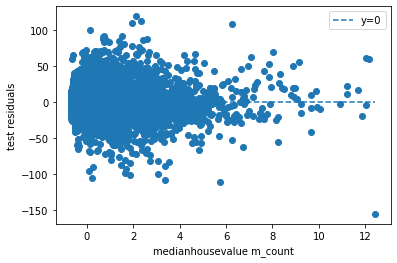

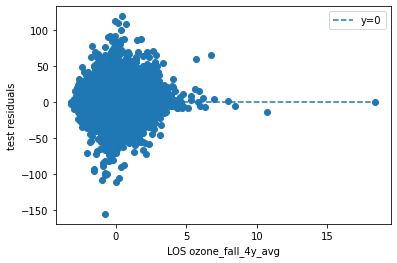

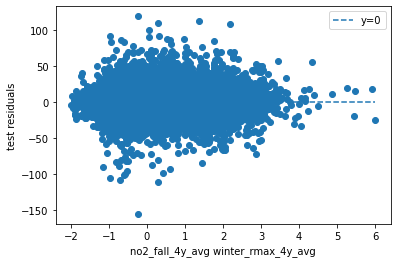

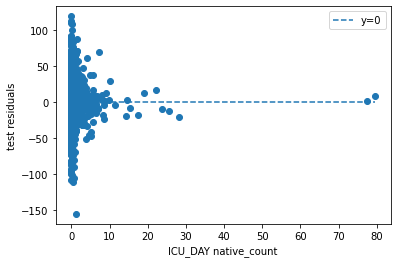

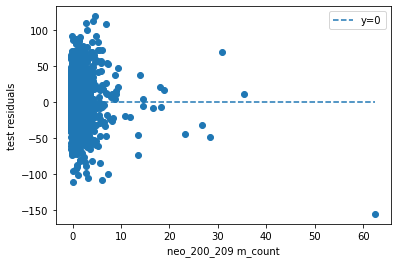

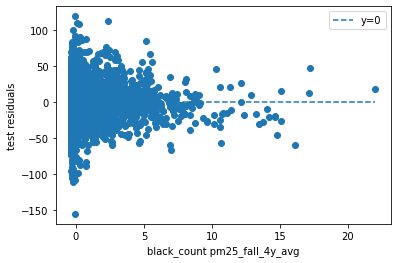

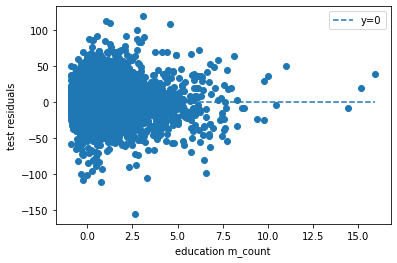

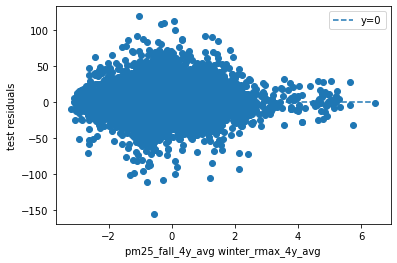

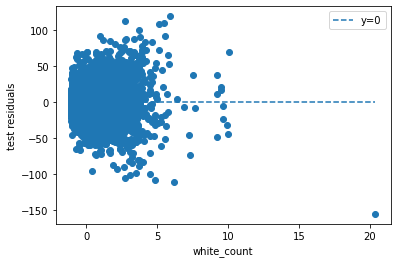

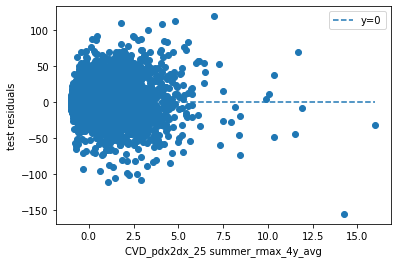

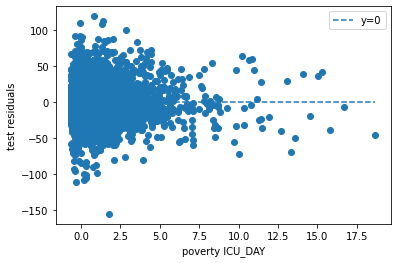

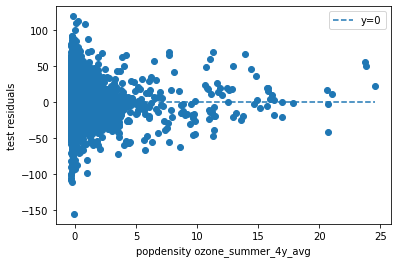

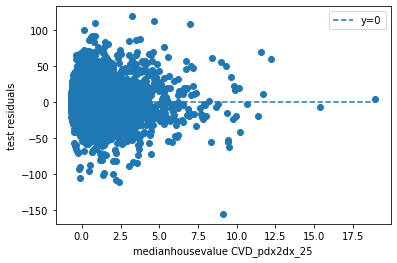

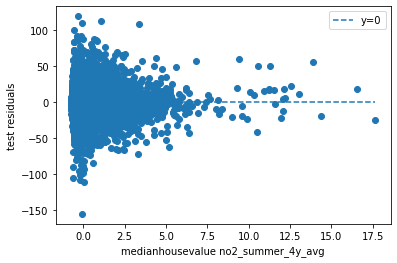

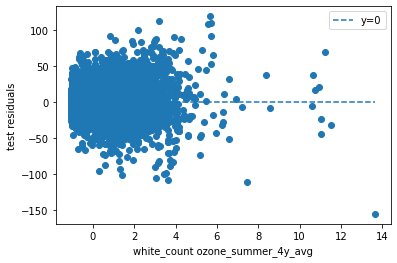

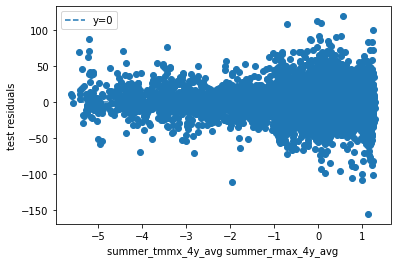

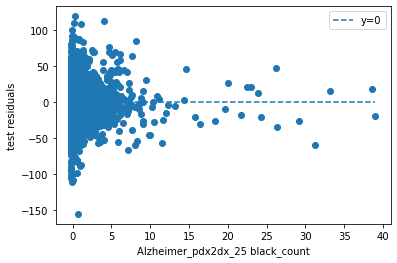

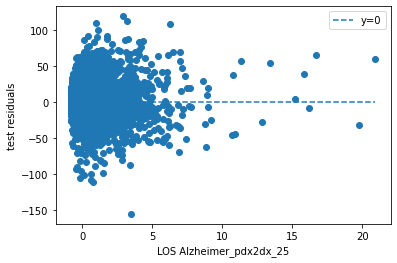

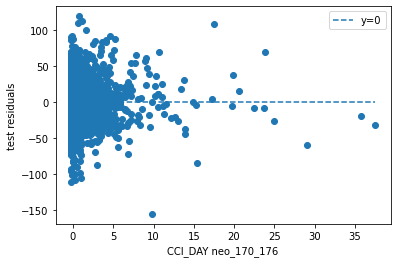

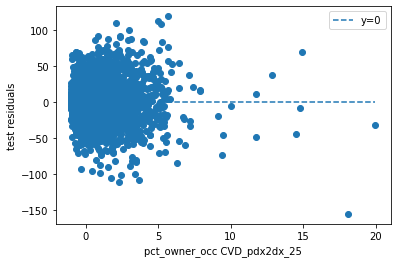

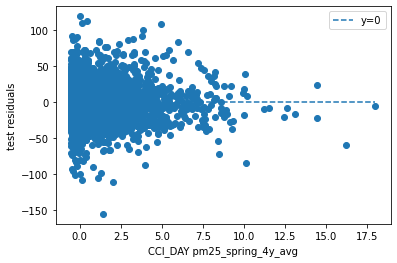

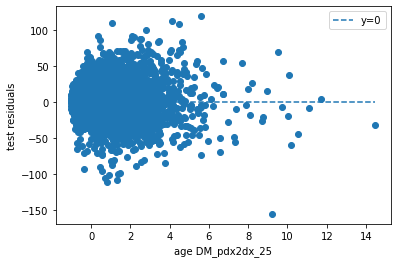

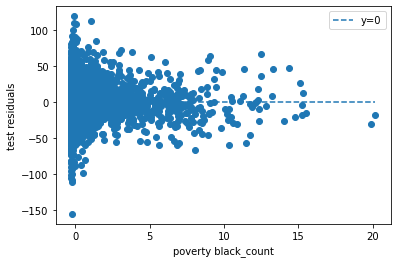

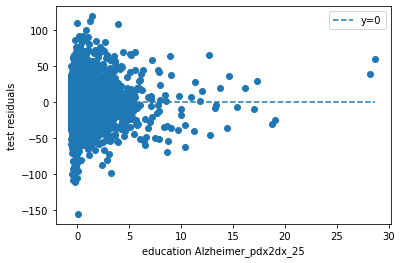

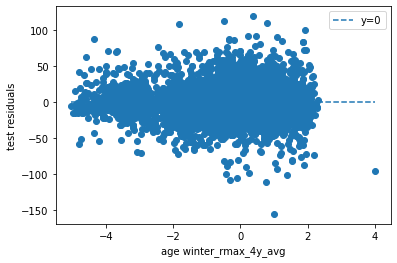

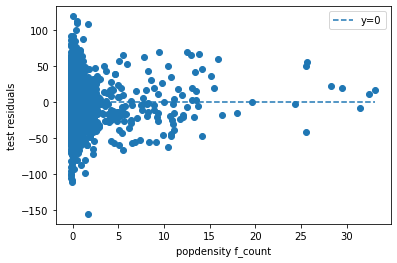

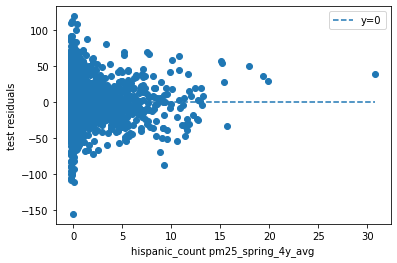

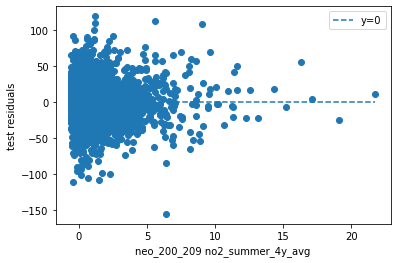

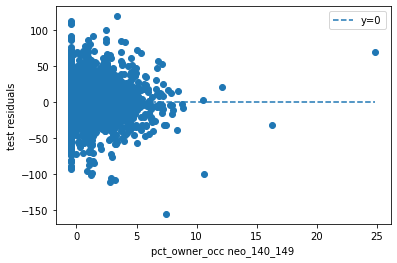

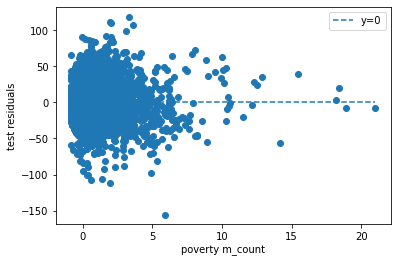

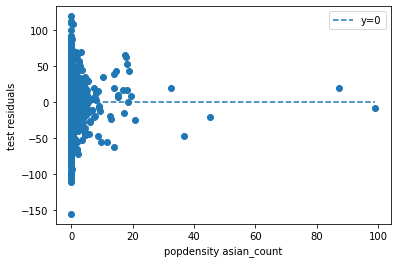

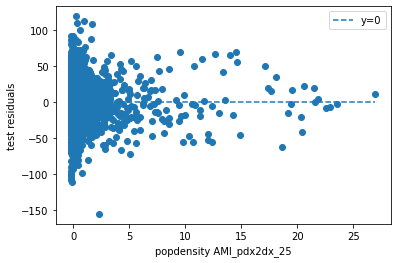

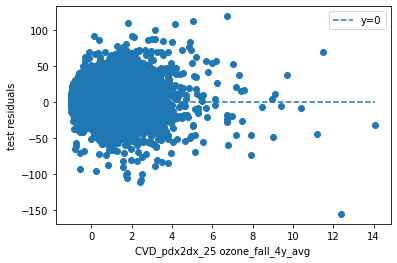

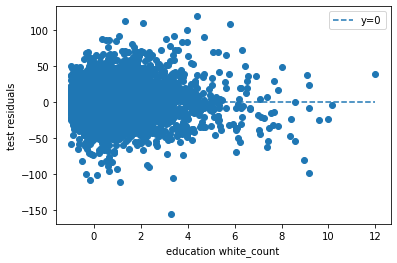

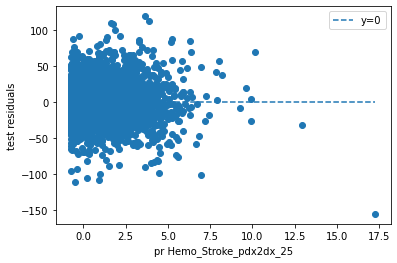

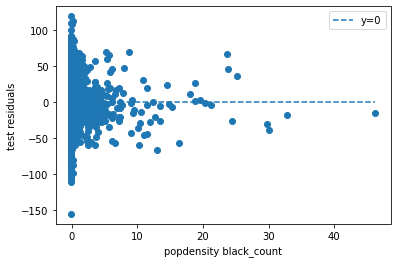

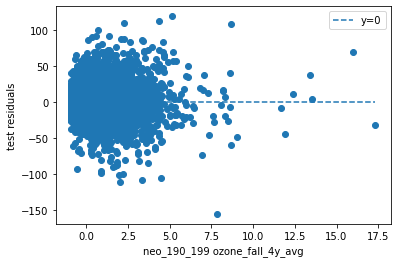

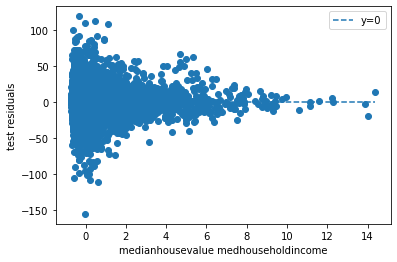

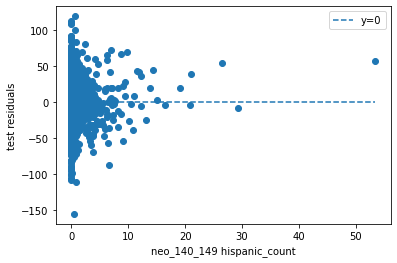

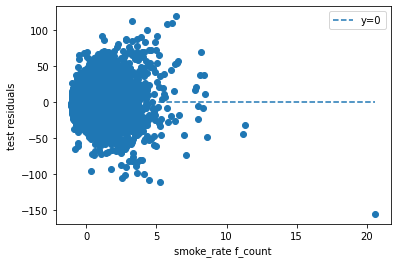

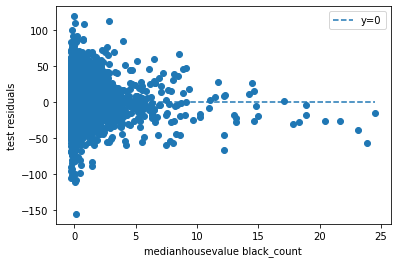

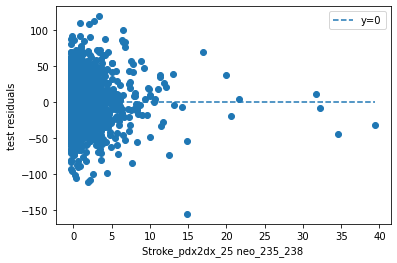

KeyboardInterrupt: 

In [115]:
plot_residuals(X_test_standardized_full3.loc[:,important_pred], y_test_full3,lasso_test_pred3)

Add Polynomial terms

In [116]:
# poverty, popdensity, medianhousevalue,medhouseholdincome, education, race_0,race_2,race_3, race_4, race_5,
# race_6, CCI_DAY, CVD_pdx_25
poly2 = PolynomialFeatures() #interaction_only=True
X_poly2 = poly2.fit_transform(df_train[x_col])

poly_names2 = poly2.get_feature_names(df_train[x_col].columns) 
X_poly_df2 = pd.DataFrame(X_poly2, columns = poly_names2)
X_poly_df2['deaths_next_year'] = df_train['deaths_next_year']

y_col = 'deaths_next_year'
non_binary_preds = poly_names2[1:] 

# split into train and test and standardize
X_train_standardized_full4, y_train_full4, X_test_standardized_full4, y_test_full4 = split_and_standardize(X_poly_df2.iloc[:,1:], poly_names2[1:], y_col, non_binary_preds)

# model
lasso_train_pred4, lasso_test_pred4, lasso_r2_train4, lasso_r2_test4, non_important_coefs2,lasso_m3 = lasso_reg(X_train_standardized_full4, X_test_standardized_full4, y_train_full4, y_test_full4)

print("Lasso Regression train pred:",lasso_r2_train4,", test pred:", lasso_r2_test4)

Lasso Regression train pred: 0.9741824599379453 , test pred: 0.9740824156445117


In [117]:
#Compute the MSE of the model
print("MSE of train data:",mean_squared_error(y_train_full4,lasso_train_pred4))
print("MSE of test data:",mean_squared_error(y_test_full4, lasso_test_pred4))

print(len(non_binary_preds) - len(non_important_coefs2))
important_preds2 = list(set(non_binary_preds) - set(non_important_coefs2))

MSE of train data: 204.35168547102504
MSE of test data: 204.32981712266997
159


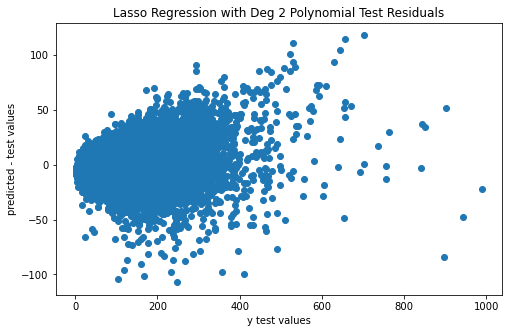

In [118]:
f,ax = plt.subplots(1, figsize=(8,5))
ax.scatter(y_test_full4, y_test_full4 - lasso_test_pred4)
ax.set_title('Lasso Regression with Deg 2 Polynomial Test Residuals')
ax.set_xlabel('y test values')
ax.set_ylabel('predicted - test values')
f.savefig('model4_residuals.png')


Look at VIF

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_standardized.values, i) for i in range(X_train_standardized.shape[1])]
vif["features"] = X_train_standardized.columns

In [ ]:
vif.round(1)
# CVD and CSD are highly correlated
# highest VIF when CSD is removed: CHF, DM, CVD

### Thoughts to do:
- residual plot not showing hommoskedeicity - some underlying relationship going on between predictors;
  need to look at this; or indicates that linear regression is not a good fit for this data
- find a way to handle for outliers (if have them?)
- implement bootstrapping and cross validation
- is normalizing the predictors in addition to standardizing applicable here?

## Additional Thoughts
Notes about residuals

When your residuals exhibit behavior violating homoskedacity, it implies that there is a relationship / behavior not being explained or accounted for. This could be due to collinearity between predictors or could be because linear regression is not the right model for your data.

Multicollinearity undermines the statistical significance of an independent variable
- Checking for multicollinearity: https://www.theanalysisfactor.com/eight-ways-to-detect-multicollinearity/ 

How to check if it’s multicollinearity? Easiest way could be to plot the variables side by side to see potential trend

Ways to check results of linear regression: https://www.theanalysisfactor.com/steps-to-take-when-your-regression-or-other-statistical-results-just-lookwrong/ 

More on homoskedacity: 
https://statisticsbyjim.com/regression/heteroscedasticity-regression/



I think residuals showing linear model is probably unfit for data and not capturing trend like it should. data doesn’t seem to exhibit polynomial trend, so will probably try two things;
- Look at data set to make sure all looks good
- Try random forest
- try all interaction terms in the model 
- try modeling residuals to determine trend (r^2)


## Regression with outcome: difference in deaths from current year to next year

In [9]:
df_train_2011 = df_train[df_train['AYEAR'] == 2011]

x_col = ['CVD_pdx2dx_25']
y_col = 'change_in_deaths'
non_binary_preds = ['CVD_pdx2dx_25']

# split into train and test and standardize
X_train_standardized_2011, y_train_2011, X_test_standardized_2011, y_test_2011 = split_and_standardize(df_train_2011, x_col, y_col, non_binary_preds)

# model
train_pred, test_pred, r2_train, r2_test = lin_reg(X_train_standardized_2011, X_test_standardized_2011, y_train_2011, y_test_2011)
print(r2_train, r2_test)

0.0013136778944276006 0.0020642183662642477


In [5]:
# plt.scatter(df_train[x_col], df_train[y_col]/df_train.population)
# plt.show()

In [6]:
# (df_train[y_col]/df_train.population).dropna().describe()

In [7]:
# df_train[y_col].describe()

In [8]:
# for i,val in enumerate(df_train[df_train.population ==0].iloc[0,:]): #.describe()
#     print(df_train.columns[i], val)
    